## How does this work?
Modern machine learning algorithms employ a wide variety of techniques. Scaling these requires a similarly wide variety of different approaches. Generally solutions fall into the following three categories

### Parallelize Scikit-Learn Directly
Scikit-Learn already provides parallel computing on a single machine with Joblib. Dask extends this parallelism to many machines in a cluster. This works well for modest data sizes but large computations, such as random forests, hyper-parameter optimization, and more.

In [ ]:
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend

client = Client()  # Connect to a Dask Cluster

with parallel_backend('dask'):
    # Your normal scikit-learn code here

### Reimplement Scalable Algorithms with Dask Array
Some machine learning algorithms are easy to write down as Numpy algorithms. In these cases we can replace Numpy arrays with Dask arrays to achieve scalable algorithms easily. This is employed for linear models, pre-processing, and clustering.



### Train Models on Large Datasets
Most estimators in scikit-learn are designed to work with NumPy arrays or scipy sparse matricies. These data structures must fit in the RAM on a single machine.

Estimators implemented in Dask-ML work well with Dask Arrays and DataFrames. This can be much larger than a single machine’s RAM. They can be distributed in memory on a cluster of machines.

In [ ]:
%matplotlib inline

In [ ]:
from dask.distributed import Client

# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client('192.168.9.30:8786')
client

In [ ]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [ ]:
# Scale up: increase n_samples or n_features
X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

In [ ]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000],
           cmap='viridis', alpha=0.25);

In [ ]:
from sklearn.datasets import make_circles
from sklearn.utils import shuffle
import pandas as pd

from timeit import default_timer as tic
import sklearn.cluster
import dask_ml.cluster
import numpy as np
from dask_ml.model_selection import train_test_split
#import seaborn as sns

Ns = [10000, 12000, 20000]


timings = []
for n in Ns:
    X, y = make_circles(n_samples=n, random_state=n, noise=0.5, factor=0.5)
    X[np.isnan(X)]=1
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    
    
    client.scatter(X_train)
    client.scatter(y_train)
    client.scatter(X_test)
    client.scatter(y_test)
    
    t1 = tic()
    try:
        clf = sklearn.cluster.SpectralClustering(n_clusters=2,n_jobs=-1).fit(X)
        timings.append(('Scikit-Learn (exact)', n, tic() - t1))
        print("Accuracy sklearn (exact): "+str(sklearn.metrics.accuracy_score(y_test, clf.fit_predict(X_test))))
    except MemoryError as error:
        timings.append(('Scikit-Learn (exact)', n, np.nan))
        print("Accuracy sklearn (exact): "+str(np.nan))
    
    t1 = tic()
    clf = dask_ml.cluster.SpectralClustering(n_clusters=2, n_components=6, n_jobs=-1).fit(X) ##number of cluster workers
    timings.append(('dask-ml (approximate)', n, tic() - t1))
    print("Accuracy dask-ml (approximate): "+str(sklearn.metrics.accuracy_score(y_test, clf.fit_predict(X_test))))




Let's talk about a paramter of the algorithm. From Dask docs [Dask-ml](https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.cluster.SpectralClustering.html)
n_components parameter is a necessary parameter in order tu distributed-parallelize some clsutering algorithm as SpectralClustering. It corresponds to the number of rows from X to use for the Nyström approximation. 
Larger n_components will improve the accuracy of the approximation, at the cost of a longer training time.

Let's back to the previuos step an take a look to the  accuracy scores. 

Even though cluster takes less time than standard approach and even though in some cases it can give a result while standard approach can't, looking the scores, seems that cluster's results are slightly different from standard approach. 

This is due to the approximations that are necessary when you work on cluster. Sometimes this approximation may improve the final results, but in general it makes them worse.

Many ML algorithms, in order to work properly with distributed computation needs to make some approximations.

In other words, when you have to choose between clustering and standard approach, you have to take in consideration this aspect.

In [ ]:
df = pd.DataFrame(timings, columns=['method', 'Number of Samples', 'Fit Time'])
df.head()

sk = df[df['method']=='Scikit-Learn (exact)']
dk = df[df['method']=='dask-ml (approximate)']
print(sk.head())
print(dk.head())

plt.plot( dk['Number of Samples'].values, dk['Fit Time'].values, color='green')
plt.plot(sk['Number of Samples'].values,sk['Fit Time'].values, color='blue')
plt.show()

### What is it happened?

While the cluster implementation have solved each task, the non distributed computation have stopped with 20000 elments due to the high memory usage!



### Incremental Learning

The incremental learning is a strategy in order to work with Big Data and distributed computation. The main idea is based on the fact that some estimators can be trained incrementally – without seeing the entire dataset at once. Scikit-Learn provdes the partial_fit API to stream batches of data to an estimator that can be fit in batches. Unfortunately, not all algorithms can be trained in this way.

Normally, if you pass a Dask Array to an estimator expecting a NumPy array, the Dask Array will be converted to a single, large NumPy array. On a single machine, you’ll likely run out of RAM and crash the program. On a distributed cluster, all the workers will send their data to a single machine and crash it.

```dask_ml.wrappers.Incremental``` provides a bridge between Dask and Scikit-Learn estimators supporting the ```partial_fit``` API. You wrap the underlying estimator in ```Incremental```. Dask-ML will sequentially pass each block of a Dask Array to the underlying estimator’s partial_fit method.

#### Hint:
```dask_ml.wrappers.Incremetnal``` currently does not work well with hyper-parameter optimization like ```sklearn.model_selection.GridSearchCV```

### Wath are the Sklearn algorithms that support distributed computing with partial_fit?

As you can find at this [link](https://scikit-learn.org/stable/modules/computing.html), the algorithms that support ```partial_fit``` are:

+ Classification
    - sklearn.naive_bayes.MultinomialNB
    - sklearn.naive_bayes.BernoulliNB
    - sklearn.linear_model.Perceptron
    - sklearn.linear_model.SGDClassifier
    - sklearn.linear_model.PassiveAggressiveClassifier
    - sklearn.neural_network.MLPClassifier
+ Regression
    - sklearn.linear_model.SGDRegressor
    - sklearn.linear_model.PassiveAggressiveRegressor
    - sklearn.neural_network.MLPRegressor
+ Clustering
    - sklearn.cluster.MiniBatchKMeans
    - sklearn.cluster.Birch
+ Decomposition / feature Extraction
    - sklearn.decomposition.MiniBatchDictionaryLearning
    - sklearn.decomposition.IncrementalPCA
    - sklearn.decomposition.LatentDirichletAllocation
+ Preprocessing
    - sklearn.preprocessing.StandardScaler
    - sklearn.preprocessing.MinMaxScaler
    - sklearn.preprocessing.MaxAbsScaler



Let's try to do something with MLPClassifier

In [ ]:
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic

X, y = make_classification(n_samples=5000000,  n_features=20, chunks=100000, random_state=42, class_sep=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)


Let's try a simple neural network on the whole dataset:

In [ ]:
# If you are a hero, brave and fearless try to launch this process with 2000 iterations. 
# When you're done tell us how much time you've spent, 
# unless you've become too old to read!
from dask.distributed import Client
from sklearn.metrics import accuracy_score
# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client('192.168.1.9:8786')
client
from sklearn.neural_network import MLPClassifier

estimator = MLPClassifier(random_state=42, 
                          max_iter=1, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
t1 = tic()
try:
    estimator.fit(X, y)
    t2 = tic()
    print("Accuracy: "+str(accuracy_score(y_test, estimator.predict(X_test))))
    print("Time: "+str(t2-t1)+"s")
except MemoryError as error:
    print("Memory error!!!")

For those that are mere mortals and are not heroes, let's see how much it uses the distributed training of a neural network!

In [ ]:
from sklearn.neural_network import MLPClassifier
import sklearn.cluster
import dask_ml.cluster
from dask.distributed import Client

from dask_ml.wrappers import Incremental
client = Client('192.168.1.9:8786')
client



estimator = MLPClassifier(random_state=42, 
                          max_iter=2000, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)

t1 = tic()
clf = Incremental(estimator)
clf.fit(X, y, classes=[0, 1])
t2 = tic()
print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
print("Time: "+str(t2-t1)+"s")


## Parallel and distributed Learning with JobLib

Due to Sklearn implement multithreaded algorithms like the RandomForest one, it's possible to distribute the computation across the cluster in order to speedup the training.
Attention! This is a differnt approach, this approach is intended to improve the speed performances not to deal with big data!

Let's see an example:


In [ ]:
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic
from dask.distributed import Client
client = Client('192.168.1.9:8786')
client
X, y = make_classification(n_samples=60000,  n_features=10, chunks=10000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

client.persist(X_train)
client.persist(y_train)

In [ ]:
from sklearn.externals.joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from dask.distributed import Client
try:
    t1 = tic()
    clf = RandomForestClassifier(n_jobs=3, n_estimators=1000, max_depth=10,   random_state=0)
    clf.fit(X_train, y_train)
    t2 = tic()
    print("Accuracy: "+str(accuracy_score(y_test, clf.predict(X_test))))
    print("Time: "+str(t2-t1)+"s") 
except MemoryError as error:
    print("Memory error!!!")
    
client = Client('192.168.1.9:8786')
client
## n_jobs = -1 means that the algorithm may use all the CPU resources available.
## By using dask scheduler all the CPU resources become "all the Cluster resources"!
with parallel_backend('dask'):
    t1 = tic()
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10,   random_state=0)
    clf.fit(X_train, y_train)
    t2 = tic()
    print("Accuracy: "+str(accuracy_score(y_test, clf.predict(X_test))))
    print("Time: "+str(t2-t1)+"s") 

Another Algorithm that can be distriuted in this way is the KNeighborsClassifier (more info [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)).

Let's see an exmaple

In [ ]:
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic

X, y = make_classification(n_samples=60000,  n_features=10, chunks=10000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

client.persist(X_train)
client.persist(y_train)

In [ ]:
from sklearn.externals.joblib import parallel_backend
from sklearn.neighbors import KNeighborsClassifier

try:
    t1 = tic()
    clf = KNeighborsClassifier(n_jobs=1, n_neighbors=6, leaf_size=40, algorithm='auto')
    clf.fit(X_train, y_train)
    t2 = tic()
    print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
    print("Time: "+str(t2-t1)+"s") 
except MemoryError as error:
    print("Memory error!!!")
    
client = Client('192.168.9.30:8786')
client
## n_jobs = -1 means that the algorithm may use all the CPU resources available.
## By using dask scheduler all the CPU resources become "all the Cluster resources"!
with parallel_backend('dask'):
    t1 = tic()
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=6, leaf_size=40, algorithm='auto')
    clf.fit(X_train, y_train)
    t2 = tic()
    print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
    print("Time: "+str(t2-t1)+"s") 

## Transformers

Machine learning algorithms often needs to rescale/tranform the features of your dataset elements. Sklearn contains a lot of transfomer (aka Scaler) in order to solve these tasks.
Anyway, even thought the trasformations are easy and in the morijity of cases perform simple stastical operations, with Big data this become a huge problem.

Similar to the pure ML Algorithms, even for those transformer are not completely supported. At the time of writing this lectures the available distributed transfomer  are:
+ [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
+ [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
+ [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
+ [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

Let's try with MinMaxScaler. As reported in [SklearnDocs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), MinMaxScaler transforms features by scaling each feature to a given range. e.g. between zero and one. The default range is 0 and 1.


In [ ]:

t1 = tic()
transformer = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
X_train = transformer.fit_transform(X_train)
t2 = tic()
print("Time: "+str(t2-t1)+"s")
X_train

Let's try with distributed computation

In [ ]:
from dask_ml.preprocessing import MinMaxScaler
t1 = tic()
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train = transformer.fit_transform(X_train)
t2 = tic()
print("Time: "+str(t2-t1)+"s")
X_train

The distributed variant have took 1/10 of the inital time!!
Attention! Even thought those scaler implement the ```partial_fit``` method, they cannot be used with IncreamentalLerning, let's see why:

In [ ]:
from dask_ml.wrappers import Incremental
t1 = tic()
transformer = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
estimator = Incremental(transformer).fit(X_train)
X_train_inc = estimator.transform(X_train)
t2 = tic()
print("Time: "+str(t2-t1)+"s")
X_train_inc

Ok, now that we have understand how work the distributed machine learning training and the transformation processes, let's try to merge them together an see the differences in terms of time:

In [ ]:
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic

X, y = make_classification(n_samples=5000000,  n_features=20, chunks=100000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [ ]:
from sklearn.neural_network import MLPClassifier

transformer = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

estimator = MLPClassifier(random_state=42, 
                          max_iter=1, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
t1 = tic()
try:
    estimator.fit(X, y)
    t2 = tic()
    print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, estimator.predict(X_test))))
    print("Time: "+str(t2-t1)+"s")
except MemoryError as error:
    print("Memory error!!!")

Let's see what change with distributed computation:

In [ ]:
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic

X, y = make_classification(n_samples=5000000,  n_features=20, chunks=100000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [ ]:
from sklearn.neural_network import MLPClassifier
from dask_ml.preprocessing import MinMaxScaler
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

estimator = MLPClassifier(random_state=42, 
                          max_iter=1, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
t1 = tic()
try:
    clf = Incremental(estimator)
    clf.fit(X, y, classes=[0, 1])
    t2 = tic()
    print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
    print("Time: "+str(t2-t1)+"s")
except MemoryError as error:
    print("Memory error!!!")

### Parallel Prediction and Transformation

In real world environment, there are some cases where you already have a trained model, but you have to predict/classify a large dataset.

Dask-ml provides some meta-estimators that parallelize and scaling out certain tasks that may not be parallelized within scikit-learn itself. 
For example, ParallelPostFit will parallelize the ```predict```, ```predict_proba``` and ```transform``` methods, enabling them to work on large (possibly larger-than memory) datasets.

Note that many scikit-learn estimators already predict and transform in parallel. This meta-estimator may still be useful in those cases when your dataset is larger than memory, as the distributed scheduler will ensure the data isn’t all read into memory at once.

Attention!
*This class is not appropriate for parallel or distributed training on large datasets!!*

In other words, tanks to dask you can predict and trasform a large sets of data. Let's try an example:

In [ ]:
from dask_ml.wrappers import ParallelPostFit
X, y = sklearn.datasets.make_classification(n_samples=1000, random_state=0)

estimator = MLPClassifier(random_state=42, 
                          max_iter=100, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
estimator = estimator.fit(X, y)

clf = ParallelPostFit(estimator=estimator,scoring='accuracy')

X_big, y_big = dask_ml.datasets.make_classification(n_samples=100000, chunks=1000)

print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_big, clf.predict(X_big))))

## Let's merge what we have learn together:

+ Get big dataset
+ Scale a big dataset
+ Split the dataset in train and test
+ Train algorithm on a big train set
+ Predict a big test set

In [ ]:
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic

X, y = make_classification(n_samples=10000000,  n_features=20, chunks=1000000, random_state=42)



In [ ]:

from sklearn.neural_network import MLPClassifier
from dask_ml.preprocessing import MinMaxScaler
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
X = transformer.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.5)

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
estimator = MLPClassifier(random_state=42, 
                          max_iter=1000, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
t1 = tic()
clf = Incremental(estimator)
clf.fit(X, y, classes=[0, 1])
clf = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
t2 = tic()
print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, clf.predict(X_test))))
print("Time: "+str(t2-t1)+"s")

### Exercise 1

Try to classify hand-written digist on the datasets. Classify the number 5 and number 9. Load the remote dataset available here: [https://www.dropbox.com/s/366wxe7458yixl4/numbers.csv?dl=1](https://www.dropbox.com/s/366wxe7458yixl4/numbers.csv?dl=1)

You have to use **MLPClassifier and Incremental learning and Parallel post fit**

In [ ]:
import dask.dataframe as dd
from sklearn.neural_network import MLPClassifier
import sklearn.cluster
import dask_ml.cluster
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
client =  #put your code
client

df =  #put your code

numbers = df[df['label'].isin([5, 9])]


y = numbers['label'].to_dask_array(lengths=True)
X = numbers[numbers.columns.difference(['label'])].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test =  #put your code

estimator =  #put your code

clf =  #put your code
clf.fit(X, y, classes=[5, 9])
clf =  #put your code

print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, clf.predict(X_test))))


### Exercise 2
Similar to the exercise 1, try to classify hand-written digist 5 and 9 on the datasets. Before the training Scale the features by using the StandardScaler.

In [ ]:
import dask.dataframe as dd
from sklearn.neural_network import MLPClassifier
import sklearn.cluster
import dask_ml.cluster
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
from dask_ml.preprocessing import StandardScaler
 #put your code
client

df =  #put your code

numbers = df[df['label'].isin([5, 9])]
numbers.head()

y = numbers['label'].to_dask_array(lengths=True)
X = numbers[numbers.columns.difference(['label'])].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = #put your code

transformer =  #put your code
 #put your code

X_train =  #put your code
X_test =  #put your code


estimator =  #put your code

clf =  #put your code
clf.fit(X, y, classes=[5, 9])
clf =  #put your code

print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, clf.predict(X_test))))


### Exercise 3
Similar to the exercise 2, try to classify hand-written 1 and 8 digist on the datasets. Before the training Scale the features by using the RobustScaler.
Use the SGDClassifier, [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) you can find how to use it

In [ ]:
import dask.dataframe as dd
from sklearn.linear_model import SGDClassifier
import sklearn.cluster
import dask_ml.cluster
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
from dask_ml.preprocessing import RobustScaler
client = #put your code
client

df = #put your code

numbers = df[df['label'].isin([1, 8])]
numbers.head()

y = numbers['label'].to_dask_array(lengths=True)
X = numbers[numbers.columns.difference(['label'])].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = #put your code

transformer = #put your code
#put your code

X_train = #put your code
X_test = #put your code


estimator = #put your code

clf = #put your code
clf.fit(X, y, classes=[1, 8])
clf = #put your code

print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, clf.predict(X_test))))


### Exercise 4

Try to separate dogs from cats on the datasets by using the ```parallel_backend('dask')``` and the ```RandomForestClasifier```. Load the remote dataset available here: [https://www.dropbox.com/s/lo8hmhczoo6c7yo/dogs_and_cats.csv?dl=1](https://www.dropbox.com/s/lo8hmhczoo6c7yo/dogs_and_cats.csv?dl=1)

Before to train use the MinMaxScaler.

In [ ]:
from sklearn.externals.joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from dask_ml.preprocessing import MinMaxScaler

df = #put your code
client = #put your code
client

y = df['label'].to_dask_array(lengths=True)
X = df[df.columns.difference(['label'])].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.5)

transformer = #put your code
#put your code

X_train = #put your code
X_test = #put your code


## n_jobs = -1 means that the algorithm may use all the CPU resources available.
## By using dask scheduler all the CPU resources become "all the Cluster resources"!
with parallel_backend('dask'):
   
    #put your code
    #put your code

print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
 

### Exercise 5
Similar to previous exercise, try to seprate cats from dogs, by using ```MLPClassifier``` and Incremental learning and Parallel post fit

In [ ]:
import dask.dataframe as dd
from sklearn.neural_network import MLPClassifier
import sklearn.cluster
import dask_ml.cluster
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from timeit import default_timer as tic
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
from dask_ml.preprocessing import StandardScaler
client = #put your code
client

df = #put your code


y = df['label'].to_dask_array(lengths=True)
X = df[df.columns.difference(['label'])].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = #put your code



transformer = #put your code
transformer = #put your code

X_train = #put your code
X_test = #put your code


estimator = #put your code


clf = #put your code
#put your code
clf = #put your code

print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, clf.predict(X_test))))


### Wath is regression?


A technique for determining the statistical relationship between two or more variables where a change in a dependent variable is associated with, and depends on, a change in one or more independent variables.

In a narrower sense, regression may refer specifically to the estimation of continuous response (dependent) variables, as opposed to the discrete response variables used in classification.
The case of a continuous dependent variable may be more specifically referred to as metric regression to distinguish it from related problems.

Not all algorithm can be used for regression problems.
The most common used algorithms are:
+ RandomForesRegressor
+ LinearRegression
+ Ridge/Lasso Regression
+ NeuralNetwork and Deep NeuralNetwork regression
+ Support Vector Regressor (aka SVM regressor/SVR)

Pay attention, some algorithm are used for ```linear model``` problems (LinearRegression/Ridge/Lasso/SVR). Other algorithm like RandomForest and NeuralNetwork are used mainly for ```non linear model```.

So, let's start with a simple LinearRegression example

In [2]:
from dask.distributed import Client
c = Client('192.168.9.44:8786')

import dask.dataframe as dd
df = dd.read_csv('https://www.dropbox.com/s/vkl89yce7xjdq4n/regression_generated.csv?dl=1')

In [3]:

# Split into training and testing data
train, test = df.random_split([0.8, 0.2])

# Separate labels from data

y_train = train['label'].values
y_test = test['label'].values
del train['label']  # remove informative column from data
del test['label']  # remove informative column from data

X_train = train.values
X_test = test.values

In [5]:
from dask_ml.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [8]:
from dask_ml.linear_model import LinearRegression
from dask_ml.metrics import mean_squared_error
## let's train and test the regression model
## the metrics for regression model are different from classification ones
## for regression models R^2 or MSE are the most used. 
## Dask allows to use RMSE in distributed mode, so we use it!

lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("MSE: "+str(mean_squared_error(y_test, y_pred)))

RMSE: 2.65320507409235


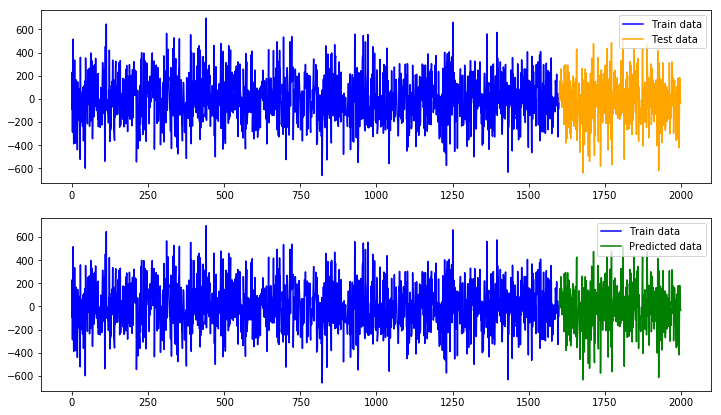

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


figsize = (12, 7)
import matplotlib.pyplot as plt
plt.figure(2, figsize=figsize)
plt.subplot(211)
plt.plot(y_train.compute(), label='Train data', color='blue')
plt.plot(np.concatenate([[np.nan for i in range(len(y_train.compute()))],y_test.compute()]), label='Test data', color='orange')
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(y_train.compute(), label='Train data', color='blue')
plt.plot(np.concatenate([[np.nan for i in range(len(y_train.compute()))],y_pred.compute()]), label='Predicted data', color='green')
plt.legend(loc='upper right')

plt.show()

### Exercise 1
Let's try to do the same, but using [```RandomForestRegressor```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (it is similar to RandomForestClassifier) with ```parallel_backend('dask')```
**Hints:** for MSE metric use ```sklearn.metrics.mean_squared_error```

In [16]:
from sklearn.externals.joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor
from dask_ml.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 


## n_jobs = -1 means that the algorithm may use all the CPU resources available.
## By using dask scheduler all the CPU resources become "all the Cluster resources"!
## put your code here
print("MSE: "+str(mean_squared_error(y_test.compute(), clf.predict(X_test))))

MSE: 5148.979078599265


Now plot the chart and compare it with the example plot.
Try to change parameters of RandomForest, such as the ```depth``` param and see what happens.

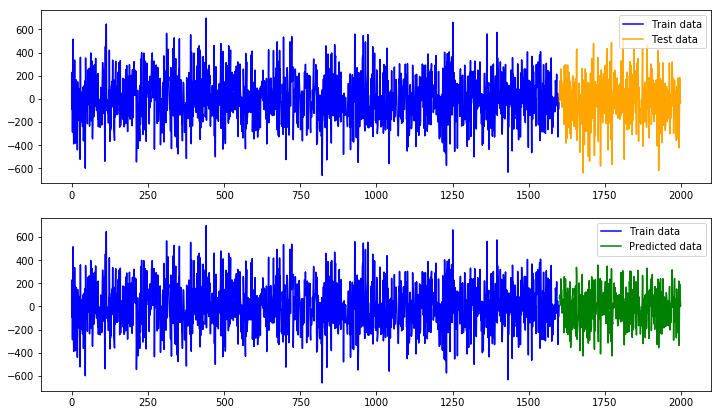

In [20]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#put your code here